In [1]:
# Basic imports, make sure they can import robustness
import torch as ch
from robustness.datasets import DATASETS
from robustness.tools.vis_tools import show_image_row
import torchvision.models as models
import torchvision.transforms as transforms

from tqdm import tqdm
import numpy as np
import PIL

%matplotlib inline

In [2]:
BATCH_SIZE = 256
NUM_WORKERS = 10

In [3]:
transforms_test = transforms.Compose([
                                    transforms.Resize(size=256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                         std=[0.229, 0.224, 0.225])
                                ])
from robustness.tools import folder

if True:
    test_set = DATASETS['imagenet']('/scratch/engstrom_scratch/imagenet')
    test_set.transform_test = transforms_test
    _, val_loader = test_set.make_loaders(NUM_WORKERS, BATCH_SIZE, 
                                          shuffle_val=False)
else:
    test_set = folder.ImageFolder(root='/scratch/engstrom_scratch/imagenet/val', 
                                  transform=transforms_test,
                                  label_mapping=None)
    val_loader = ch.utils.data.DataLoader(test_set, 
                                          num_workers=NUM_WORKERS, 
                                          batch_size=BATCH_SIZE)

==> Preparing dataset imagenet..


In [4]:
model = models.resnet18(pretrained=True).cuda()
model.eval()
model = ch.nn.DataParallel(model)
pass

In [5]:
if False:
    correct_cnt, total = 0, 0
    it = tqdm(enumerate(val_loader), total=len(val_loader))
    for itidx, (im, targ) in it:
        with ch.no_grad():
            im, targ = im.cuda(), targ.cuda()
            op = model(im)
            pred = op.argmax(dim=1)
            correct = targ.eq(pred)

            correct_cnt += np.sum(correct.cpu().numpy())
            total += len(targ)
            it.set_description(f"Accuracy: {100 * correct_cnt/total:.2f}")

0.70: 100%|██████████| 196/196 [01:02<00:00,  3.14it/s]


In [8]:
def get_gradient(m, im, targ):
    im, targ = im.cuda(), targ.cuda()
    op = m(im)
    loss = ch.nn.CrossEntropyLoss()(op, targ)
    grad, = ch.autograd.grad(loss, [im])
    return grad

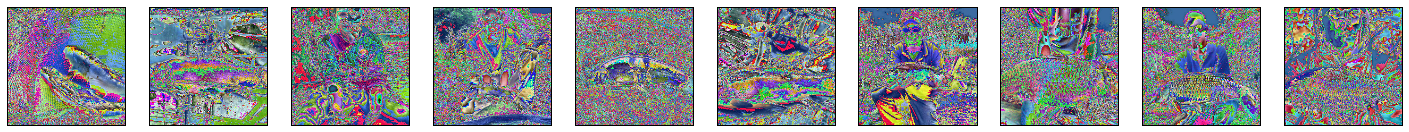

In [6]:
_, (img, targ) = next(enumerate(val_loader))

In [8]:
ch.max(img), ch.min(img)
#show_image_row([img[:10]])

(tensor(2.6400), tensor(-2.1179))